# Regression Notebook (for a non-technical audience)

# Introduction

#### Every year, 256 fortunate college football standouts are selected in the NFL draft to join one of 32 American football teams. Forecasting where each player will get selected throughout 256 is an extremely difficult process. Up until the night of the draft itself, the draft needs and dynamic for any team can change rather quickly. In general, the draft dynamic is influenced primarily by: team needs, available players, college football statistics, draft combine performance, and some other metrics. My study will focus on the particular influence of the draft combine. What is the draft combine? The draft combine is a display of available players showcasing their key physical attributes which matter most in professional American football. Players will be asked to run 40 yards, record vertical leaps, as well as other tasks. 
#### The draft combine is heavily followed and covered by sports media. In addition, running it takes time and setup and scouts will all attend the combine and track results while making additional notes. WIth all this effort put into the combine, how important is it in the end? I hope to answer how much of the selection placement  can be explained by the combine alone

# Process: Collection, Preparation, and Modeling

#### My data comes from Kaggle and can be found at https://www.kaggle.com/savvastj/nfl-combine-data
#### The data contained information from 2000 up until 2018. There were 6218 total entries, covering 16 different categories. I placed my focus on the eight combine activities listed as well as the player's position (not including kickers or punters). My goal was to attempt to predict the particular pick of a random player based on their combine results and position

#### After organizing my datas I carefully went through all the important steps of cleaning my data and optimizing my features to better predict results (more below)

#### Finally, I modeled my data to see how well it could explain the expected draft selection spot (more below)

## Collection

## Import libraries

##### Here, I will "import" all the necessary pyton functions I will later use to perform necessary tasks. These functions are not available until I properly "import" them

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import seaborn as sns
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import RFE
from numpy.polynomial.polynomial import polyfit
from pandas import Series
import matplotlib.pylab as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima_model import ARMA
from statsmodels.compat import lzip

## Load data

##### Here, I use one of the above imports to copy a data set downloaded on my computer into a python notebook in the form of a Data Frame, which is basically the same things a spread sheet

In [25]:
!pwd

/Users/flatironschool/Documents/Mod_4_Project_Folder/mod_4_project


In [26]:
!ls

BrentOilPrices.csv        combine_data.csv          practice_notebook.ipynb
Non-technical.ipynb       mod_4_TS.ipynb
README.md                 mod_4_proj_notebook.ipynb


In [27]:
# https://www.kaggle.com/savvastj/nfl-combine-data

In [28]:
combine_data = pd.read_csv('combine_data.csv')

In [70]:
abcde = pd.read_csv('combine_data.csv')
abcde.shape

(6218, 16)

### Preparation

## Get data ready

##### Here I filter out the features I do not find important such as what year the draft took place in. I also will  make sure that my data does not contain any missing values, as that will prevent me from evaluating my data accurately

In [30]:
combine_data.Pick.fillna(0,inplace=True)
combine_data = combine_data[combine_data.Pick>0]
combine_data.set_index('Player',inplace=True)

In [31]:
combine_data.drop(['Pfr_ID','AV','Team','Round','Year'],axis=1,inplace=True)

In [32]:
combine_data.Forty.fillna(0,inplace=True)
combine_data = combine_data[combine_data.Forty>0]
combine_data.Vertical.fillna(0,inplace=True)
combine_data = combine_data[combine_data.Vertical>0]
combine_data.BenchReps.fillna(0,inplace=True)
combine_data = combine_data[combine_data.BenchReps>0]
combine_data.BroadJump.fillna(0,inplace=True)
combine_data = combine_data[combine_data.BroadJump>0]
combine_data.Cone.fillna(0,inplace=True)
combine_data = combine_data[combine_data.Cone>0]
combine_data.Shuttle.fillna(0,inplace=True)
combine_data = combine_data[combine_data.Shuttle>0]

In [33]:
print(combine_data.shape)
combine_data.head()

(1822, 10)


,Pos,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle,Pick
Player,,,,,,,,,,
Darnell Alford,OT,76,334,5.56,25.0,23.0,94.0,8.48,4.98,188.0
Reggie Austin,CB,69,175,4.44,35.0,17.0,119.0,7.03,4.14,125.0
Rashidi Barnes,FS,72,208,4.62,35.0,10.0,114.0,6.92,4.32,225.0
David Barrett,CB,70,199,4.44,37.5,16.0,116.0,6.81,4.04,102.0
Rogers Beckett,FS,73,207,4.62,39.5,15.0,119.0,6.48,4.29,43.0


## Categorical features

##### Next, I will create a way to contextualize categorical features in a quantittative manner. I wlll then ensure that my data does not contain outliers which will unfairly skew the results improperly. Finally I combine my categorical data, now visualized quantitatively, with the rest of the numerical data

In [34]:
combine_data_cat = pd.get_dummies(combine_data.Pos)

In [35]:
combine_data_cat.drop('C',axis=1,inplace=True)

In [36]:
combine_data_cat.head(1)

,CB,DE,DT,FB,FS,ILB,LS,OG,OLB,OT,QB,RB,SS,TE,WR
Player,,,,,,,,,,,,,,,
Darnell Alford,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [37]:
combine_atg = combine_data.copy()
combine_atg.drop(['Pos'],axis=1,inplace=True)

#### Filter outliers

In [38]:
combine_atg = combine_atg[(np.abs(stats.zscore(combine_atg)) <= 2.5).all(axis=1)]

In [39]:
combine_atg['CB']=combine_data_cat['CB']
combine_atg['DE']=combine_data_cat['DE']
combine_atg['DT']=combine_data_cat['DT']
combine_atg['FB']=combine_data_cat['FB']
combine_atg['FS']=combine_data_cat['FS']
combine_atg['ILB']=combine_data_cat['ILB']
combine_atg['LS']=combine_data_cat['LS']
combine_atg['OG']=combine_data_cat['OG']
combine_atg['OT']=combine_data_cat['OT']
combine_atg['QB']=combine_data_cat['QB']
combine_atg['OLB']=combine_data_cat['OLB']
combine_atg['SS']=combine_data_cat['SS']
combine_atg['TE']=combine_data_cat['TE']
combine_atg['WR']=combine_data_cat['WR']

In [40]:
print(combine_atg.shape)
combine_atg.head()

(1737, 23)


,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle,Pick,CB,...,FS,ILB,LS,OG,OT,QB,OLB,SS,TE,WR
Player,,,,,,,,,,,,,,,,,,,,,
Reggie Austin,69,175,4.44,35.0,17.0,119.0,7.03,4.14,125.0,1,...,0,0,0,0,0,0,0,0,0,0
Rashidi Barnes,72,208,4.62,35.0,10.0,114.0,6.92,4.32,225.0,0,...,1,0,0,0,0,0,0,0,0,0
David Barrett,70,199,4.44,37.5,16.0,116.0,6.81,4.04,102.0,1,...,0,0,0,0,0,0,0,0,0,0
Rogers Beckett,73,207,4.62,39.5,15.0,119.0,6.48,4.29,43.0,0,...,1,0,0,0,0,0,0,0,0,0
Brad Bedell,76,302,5.07,31.5,17.0,103.0,7.76,4.58,206.0,0,...,0,0,0,1,0,0,0,0,0,0


## Correlation

##### Here, I ensure that my model doesn't give unfair meaning to extra variables. Having highly correlated variables means only one is necessary and that having both will give you a misrepresentation (albeit more pleasing) of how accurate your predictions are. Using a heatmap and correlation matrix I can visualiuze where this data lies. I will then remove said data.

In [41]:
combine_atg_num=combine_atg[['Ht','Wt','Forty','Vertical','BenchReps','BroadJump','Cone','Shuttle']]

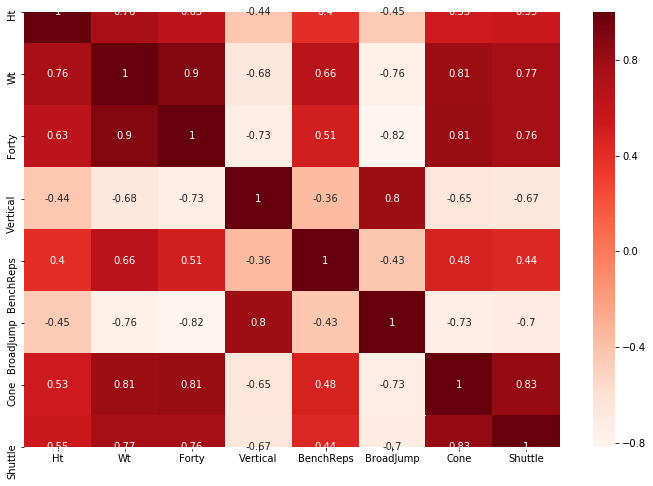

In [42]:
plt.figure(figsize=(12,8))
cor = combine_atg_num.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [43]:
combine_atg.drop('Wt',axis=1,inplace=True)
combine_atg.drop('Cone',axis=1,inplace=True)
combine_atg.drop('BroadJump',axis=1,inplace=True)

In [44]:
abs(combine_atg.corr()>=.8)

,Ht,Forty,Vertical,BenchReps,Shuttle,Pick,CB,DE,DT,FB,FS,ILB,LS,OG,OT,QB,OLB,SS,TE,WR
Ht,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Forty,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Vertical,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
BenchReps,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Shuttle,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Pick,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
CB,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
DE,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
DT,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
FB,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False


## Train - Test - Split

##### Here, I take my entire data set and split it into two sections: One to base my model on, and one to validate my model on. In other words, I will perform a process with 70% of my data. If those resutls are the same when usin the other 30% of the data while going throught the same process, I can confidently say my model is completely dependent on the initial 70%, but will also work for each newe data point added

In [45]:
df_features = combine_atg.drop('Pick',axis=1)

In [46]:
df_target = combine_atg[['Pick']]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(df_features,df_target,test_size=0.3,random_state=45)

In [48]:
print(X_train.shape[0]==y_train.shape[0])
print(X_test.shape[0]==y_test.shape[0])

True
True


## Check messy model

##### Before, I begin my process of optimizing the "test" data, I will check the accuracy of my entire data set and compare with my later work to see if my optimization process meaningfully made my predictions more accurate

#### Using intercept

In [49]:
lr = LinearRegression()
lr.fit(df_features, df_target)
y_hat_f = lr.predict(df_features)
print(f"r^2: {r2_score(df_target, y_hat_f)}")
print(f"rmse: {np.sqrt(mean_squared_error(df_target, y_hat_f))}")

r^2: 0.09692052403453866
rmse: 65.97490038952257


#### Not using intercept

In [50]:
feat_mod=sm.OLS(df_target,df_features)
feat_results=feat_mod.fit()
feat_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Pick   R-squared (uncentered):                   0.765
Model:                            OLS   Adj. R-squared (uncentered):              0.763
Method:                 Least Squares   F-statistic:                              294.7
Date:                Wed, 08 Jan 2020   Prob (F-statistic):                        0.00
Time:                        11:18:42   Log-Likelihood:                         -9743.4
No. Observations:                1737   AIC:                                  1.952e+04
Df Residuals:                    1718   BIC:                                  1.963e+04
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Ht            -4.0158      0.841     -4.772      0.000      -5.666      -2.365
Forty         93.9343     11.148      8.426      0.000      72.069     115.800
Vertical      -0.6663      0.518     -1.285      0.199      -1.683       0.350
BenchReps     -1.8537      0.347     -5.344      0.000      -2.534      -1.173
Shuttle        6.9163     10.213      0.677      0.498     -13.116      26.948
CB            -5.4957      7.271     -0.756      0.450     -19.756       8.765
DE             3.6322      7.275      0.499      0.618     -10.638      17.902
DT           -28.5988      7.786     -3.673      0.000     -43.871     -13.327
FB            49.5267     11.188      4.427      0.000      27.583      71.470
FS            10.0573      9.248      1.088      0.277      -8.081      28.195
ILB           12.9713      8.917      1.455      0.146      -4.519      30.461
LS            51.3759     66.650      0.771      0.441     -79.349     182.101
OG           -30.7340      8.831     -3.480      0.001     -48.055     -13.413
OT           -37.9178      7.885     -4.809      0.000     -53.383     -22.453
QB            13.3030     47.243      0.282      0.778     -79.357     105.963
OLB            7.8485      7.223      1.087      0.277      -6.317      22.014
SS            29.8553      9.846      3.032      0.002      10.543      49.167
TE            16.4384      8.503      1.933      0.053      -0.238      33.115
WR            19.4799      8.273      2.355      0.019       3.253      35.707
==============================================================================
Omnibus:                      208.707   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.754
Skew:                           0.295   Prob(JB):                     1.31e-17
Kurtosis:                       2.147   Cond. No.                     3.52e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Train data

##### Here, I have selected 70% of my original data for which I will build a model on. I will perform the Box-Cox transform which ensures all my data is normally distributed. I will apply a standard scale to remove any effect of a particular feature having an outsized and undeserved impact. I will then regularize the data available to place heavier focus on more impprtant predictors 

In [51]:
print(X_train.shape)
X_train.head()

(1215, 19)


,Ht,Forty,Vertical,BenchReps,Shuttle,CB,DE,DT,FB,FS,ILB,LS,OG,OT,QB,OLB,SS,TE,WR
Player,,,,,,,,,,,,,,,,,,,
Lance Kendricks,75,4.65,34.5,25.0,4.15,0,0,0,0,0,0,0,0,0,0,0,0,1,0
Jonathan Allen,75,5.00,30.0,21.0,4.50,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Kraig Urbik,77,5.25,24.0,29.0,4.89,0,0,0,0,0,0,0,1,0,0,0,0,0,0
Levine Toilolo,80,4.86,31.0,17.0,4.57,0,0,0,0,0,0,0,0,0,0,0,0,1,0
Tony Scheffler,77,4.54,33.5,17.0,4.01,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [52]:
print('not normal: Wt, Ht, Forty, Cone')

not normal: Wt, Ht, Forty, Cone


#### Box-Cox: normalize

In [53]:
X_train['Forty']=list(stats.boxcox(abs(X_train['Forty'])))[0]
X_train['Ht']=list(stats.boxcox(abs(X_train['Ht'])))[0]
#X_train['Cone']=list(stats.boxcox(abs(X_train['Cone'])))[0]
#X_train['Wt']=list(stats.boxcox(abs(X_train['Wt'])))[0]

#### Standard scale

In [54]:
ss = StandardScaler()
ss.fit_transform(X_train[['Ht']]).flatten()
X_train['Ht'] = ss.fit_transform(X_train[['Ht']]).flatten()
ss.fit_transform(X_train[['Forty']]).flatten()
X_train['Forty'] = ss.fit_transform(X_train[['Forty']]).flatten()
ss.fit_transform(X_train[['Vertical']]).flatten()
X_train['Vertical'] = ss.fit_transform(X_train[['Vertical']]).flatten()
ss.fit_transform(X_train[['BenchReps']]).flatten()
X_train['BenchReps'] = ss.fit_transform(X_train[['BenchReps']]).flatten()

In [55]:
print(X_train.shape)
X_train.head()

(1215, 19)


,Ht,Forty,Vertical,BenchReps,Shuttle,CB,DE,DT,FB,FS,ILB,LS,OG,OT,QB,OLB,SS,TE,WR
Player,,,,,,,,,,,,,,,,,,,
Lance Kendricks,0.363813,-0.256900,0.310519,0.515523,4.15,0,0,0,0,0,0,0,0,0,0,0,0,1,0
Jonathan Allen,0.363813,0.895141,-0.796236,-0.115412,4.50,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Kraig Urbik,1.161754,1.459443,-2.271908,1.146458,4.89,0,0,0,0,0,0,0,1,0,0,0,0,0,0
Levine Toilolo,2.419202,0.494904,-0.550290,-0.746347,4.57,0,0,0,0,0,0,0,0,0,0,0,0,1,0
Tony Scheffler,1.161754,-0.742000,0.064573,-0.746347,4.01,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### Score

##### Here, I will evaluate the accuracy of the data according to a couple methods based on the improvements I have done

#### Using Ridge regularization

In [57]:
ridge_reg = Ridge(alpha=0.05)
ridge_reg.fit(X_train,y_train)
ridge_coef_tr = pd.DataFrame(ridge_reg.coef_)
ridge_coef_tr.columns=X_train.columns
print(ridge_reg.score(X_train,y_train))
ridge_coef_tr

0.1226947858005345


,Ht,Forty,Vertical,BenchReps,Shuttle,CB,DE,DT,FB,FS,ILB,LS,OG,OT,QB,OLB,SS,TE,WR
0,-16.614055,30.813026,-5.422752,-12.81366,-5.156713,-12.108519,-0.583482,-27.893205,42.917206,-1.48652,1.973037,34.615042,-28.495538,-27.513583,3.049073,-4.343384,32.212545,9.051348,18.999185


#### Using intercept

In [58]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_hat_tr = lr.predict(X_train)
coef_df = pd.DataFrame(lr.coef_)
coef_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-16.613306,30.829291,-5.420624,-12.809296,-5.134085,-12.07366,-0.579999,-27.918412,43.002498,-1.456608,1.987736,36.349448,-28.534867,-27.543463,3.132319,-4.32848,32.276211,9.069583,19.045054


In [59]:
print(f"r^2: {r2_score(y_train, y_hat_tr)}")
print(f"rmse: {np.sqrt(mean_squared_error(y_train, y_hat_tr))}")

r^2: 0.1226953545727375
rmse: 66.41202098685099


In [60]:
X_int_train = sm.add_constant(X_train)
mod = sm.OLS(y_train,X_int_train).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Pick   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     8.796
Date:                Wed, 08 Jan 2020   Prob (F-statistic):           7.67e-24
Time:                        11:18:52   Log-Likelihood:                -6822.0
No. Observations:                1215   AIC:                         1.368e+04
Df Residuals:                    1195   BIC:                         1.379e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        145.6709     58.701      2.482      0.013      30.502     260.840
Ht           -16.6133      3.297     -5.040      0.000     -23.081     -10.146
Forty         30.8293      4.303      7.164      0.000      22.387      39.272
Vertical      -5.4206      3.040     -1.783      0.075     -11.385       0.544
BenchReps    -12.8093      2.647     -4.839      0.000     -18.002      -7.616
Shuttle       -5.1341     13.314     -0.386      0.700     -31.255      20.987
CB           -12.0737      9.182     -1.315      0.189     -30.088       5.941
DE            -0.5800      9.316     -0.062      0.950     -18.857      17.697
DT           -27.9184      9.890     -2.823      0.005     -47.322      -8.515
FB            43.0025     13.741      3.129      0.002      16.043      69.962
FS            -1.4566     10.942     -0.133      0.894     -22.924      20.011
ILB            1.9877     10.810      0.184      0.854     -19.221      23.196
LS            36.3494     67.328      0.540      0.589     -95.744     168.443
OG           -28.5349     11.608     -2.458      0.014     -51.309      -5.761
OT           -27.5435     11.132     -2.474      0.013     -49.385      -5.702
QB             3.1323     47.773      0.066      0.948     -90.596      96.861
OLB           -4.3285      8.611     -0.503      0.615     -21.222      12.565
SS            32.2762     11.701      2.758      0.006       9.320      55.232
TE             9.0696     10.730      0.845      0.398     -11.982      30.121
WR            19.0451     10.068      1.892      0.059      -0.708      38.798
==============================================================================
Omnibus:                      146.936   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.516
Skew:                           0.262   Prob(JB):                     6.51e-12
Kurtosis:                       2.138   Cond. No.                         158.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Not using intercept

In [61]:
mod = sm.OLS(y_train,X_train).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Pick   R-squared (uncentered):                   0.768
Model:                            OLS   Adj. R-squared (uncentered):              0.764
Method:                 Least Squares   F-statistic:                              208.4
Date:                Wed, 08 Jan 2020   Prob (F-statistic):                        0.00
Time:                        11:18:54   Log-Likelihood:                         -6825.1
No. Observations:                1215   AIC:                                  1.369e+04
Df Residuals:                    1196   BIC:                                  1.379e+04
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Ht           -17.8292      3.267     -5.457      0.000     -24.239     -11.420
Forty         28.6298      4.220      6.784      0.000      20.350      36.909
Vertical      -3.5791      2.954     -1.211      0.226      -9.375       2.217
BenchReps    -13.0475      2.651     -4.922      0.000     -18.248      -7.847
Shuttle       27.7285      1.376     20.158      0.000      25.030      30.427
CB            -7.4846      9.013     -0.830      0.406     -25.168      10.199
DE             1.5243      9.297      0.164      0.870     -16.716      19.765
DT           -28.8151      9.905     -2.909      0.004     -48.248      -9.382
FB            46.0705     13.715      3.359      0.001      19.162      72.979
FS             2.5918     10.843      0.239      0.811     -18.681      23.865
ILB            7.4754     10.604      0.705      0.481     -13.329      28.280
LS            43.1367     67.417      0.640      0.522     -89.132     175.405
OG           -30.2619     11.612     -2.606      0.009     -53.044      -7.480
OT           -29.4443     11.130     -2.645      0.008     -51.281      -7.608
QB             5.6768     47.865      0.119      0.906     -88.232      99.585
OLB           -0.0700      8.456     -0.008      0.993     -16.660      16.520
SS            36.5650     11.597      3.153      0.002      13.812      59.318
TE            13.2126     10.622      1.244      0.214      -7.627      34.053
WR            20.9532     10.060      2.083      0.037       1.216      40.691
==============================================================================
Omnibus:                      134.749   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.082
Skew:                           0.265   Prob(JB):                     1.33e-11
Kurtosis:                       2.158   Cond. No.                         154.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Repeat on test data

##### Here, I will repeat the process on my test data and validate based on the predictions of the train data

In [62]:
print(X_test.shape)
X_test.head()

(522, 19)


,Ht,Forty,Vertical,BenchReps,Shuttle,CB,DE,DT,FB,FS,ILB,LS,OG,OT,QB,OLB,SS,TE,WR
Player,,,,,,,,,,,,,,,,,,,
Rakeem Nunez-Roches,74,5.02,34.0,26.0,4.69,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Will Davis-02,71,4.51,35.5,16.0,4.02,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Daryn Colledge,76,5.05,32.5,21.0,4.58,0,0,0,0,0,0,0,0,1,0,0,0,0,0
Bashaud Breeland,71,4.62,34.5,11.0,4.33,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Al-Quadin Muhammad,75,4.88,30.5,22.0,4.47,0,1,0,0,0,0,0,0,0,0,0,0,0,0


#### Box-Cox: normalize

In [63]:
X_test['Forty']=list(stats.boxcox(abs(X_test['Forty'])))[0]
X_test['Ht']=list(stats.boxcox(abs(X_test['Ht'])))[0]

#### Standard scale

In [64]:
ss = StandardScaler()
ss.fit_transform(X_test[['Ht']]).flatten()
X_test['Ht'] = ss.fit_transform(X_test[['Ht']]).flatten()
ss.fit_transform(X_test[['Forty']]).flatten()
X_test['Forty'] = ss.fit_transform(X_test[['Forty']]).flatten()
ss.fit_transform(X_test[['Vertical']]).flatten()
X_test['Vertical'] = ss.fit_transform(X_test[['Vertical']]).flatten()
ss.fit_transform(X_test[['BenchReps']]).flatten()
X_test['BenchReps'] = ss.fit_transform(X_test[['BenchReps']]).flatten()

In [65]:
print(X_test.shape)
X_test.head()

(522, 19)


,Ht,Forty,Vertical,BenchReps,Shuttle,CB,DE,DT,FB,FS,ILB,LS,OG,OT,QB,OLB,SS,TE,WR
Player,,,,,,,,,,,,,,,,,,,
Rakeem Nunez-Roches,-0.052873,0.991874,0.205579,0.801941,4.69,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Will Davis-02,-1.162439,-0.863337,0.601077,-0.848092,4.02,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Daryn Colledge,0.777277,1.070283,-0.189920,-0.023075,4.58,0,0,0,0,0,0,0,0,1,0,0,0,0,0
Bashaud Breeland,-1.162439,-0.361708,0.337411,-1.673108,4.33,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Al-Quadin Muhammad,0.352761,0.588387,-0.717252,0.141928,4.47,0,1,0,0,0,0,0,0,0,0,0,0,0,0


### Score

#### Using Ridge regularization

In [66]:
ridge_reg = Ridge(alpha=0.05)
ridge_reg.fit(X_train,y_train)
ridge_coef_tr = pd.DataFrame(ridge_reg.coef_)
ridge_coef_tr.columns=X_train.columns
print(ridge_reg.score(X_test,y_test))
ridge_coef_tr

0.03413988305094029


,Ht,Forty,Vertical,BenchReps,Shuttle,CB,DE,DT,FB,FS,ILB,LS,OG,OT,QB,OLB,SS,TE,WR
0,-16.614055,30.813026,-5.422752,-12.81366,-5.156713,-12.108519,-0.583482,-27.893205,42.917206,-1.48652,1.973037,34.615042,-28.495538,-27.513583,3.049073,-4.343384,32.212545,9.051348,18.999185


#### Using intercept

In [67]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_hat_te = lr.predict(X_test)
coef_df = pd.DataFrame(lr.coef_)
coef_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-16.613306,30.829291,-5.420624,-12.809296,-5.134085,-12.07366,-0.579999,-27.918412,43.002498,-1.456608,1.987736,36.349448,-28.534867,-27.543463,3.132319,-4.32848,32.276211,9.069583,19.045054


In [68]:
print(f"r^2: {r2_score(y_test, y_hat_te)}")
print(f"rmse: {np.sqrt(mean_squared_error(y_test, y_hat_te))}")

r^2: 0.03412676710583884
rmse: 64.61303545195494


#### Not using intercept

In [69]:
mod = sm.OLS(y_test,X_test).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Pick   R-squared (uncentered):                   0.776
Model:                            OLS   Adj. R-squared (uncentered):              0.768
Method:                 Least Squares   F-statistic:                              102.6
Date:                Wed, 08 Jan 2020   Prob (F-statistic):                   1.85e-151
Time:                        11:19:01   Log-Likelihood:                         -2898.4
No. Observations:                 522   AIC:                                      5831.
Df Residuals:                     505   BIC:                                      5903.
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Ht           -11.2439      4.709     -2.388      0.017     -20.496      -1.992
Forty         23.3262      5.830      4.001      0.000      11.872      34.780
Vertical       0.0523      3.957      0.013      0.989      -7.721       7.826
BenchReps     -9.6103      3.738     -2.571      0.010     -16.955      -2.266
Shuttle       24.0734      2.003     12.021      0.000      20.139      28.008
CB             7.7466     12.974      0.597      0.551     -17.744      33.237
DE            13.6100     13.224      1.029      0.304     -12.372      39.592
DT           -30.7481     14.952     -2.056      0.040     -60.124      -1.372
FB            45.6156     18.919      2.411      0.016       8.445      82.786
FS            33.7167     16.446      2.050      0.041       1.406      66.027
ILB           20.6062     15.313      1.346      0.179      -9.480      50.692
LS          1.433e-15   3.43e-15      0.418      0.676    -5.3e-15    8.16e-15
OG           -12.8849     16.473     -0.782      0.434     -45.248      19.478
OT           -32.1628     16.140     -1.993      0.047     -63.873      -0.453
QB          -7.29e-15   3.64e-15     -2.002      0.046   -1.44e-14   -1.36e-16
OLB           29.3204     12.617      2.324      0.021       4.533      54.108
SS            11.6130     17.896      0.649      0.517     -23.546      46.772
TE            34.9927     14.632      2.392      0.017       6.246      63.739
WR            29.5007     14.558      2.026      0.043       0.899      58.102
==============================================================================
Omnibus:                       30.960   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.444
Skew:                           0.359   Prob(JB):                     3.64e-05
Kurtosis:                       2.349   Cond. No.                     4.83e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.3e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""